In [1]:
import numpy as np
import gym
import time
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    return np.random.choice(np.arange(action_n), p=policy)

# QLearning implementation

# Monte-carlo and SARSA copypaste from practice

In [4]:
def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99):
    total_rewards = []
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))
    
    for episode in tqdm(range(episode_n)):
        epsilon = 1 - episode / episode_n
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        
        state = env.reset()
        for _ in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            trajectory['actions'].append(action)
            
            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)
            
            if done:
                break
                
        total_rewards.append(sum(trajectory['rewards']))
        
        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]
            
        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1
            
    return total_rewards
    

In [5]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    
    for episode in tqdm(range(episode_n)):
        epsilon = 1 / (episode + 1)
        
        state = env.reset()
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)
            
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])
            
            state = next_state
            action = next_action
            
            total_rewards[episode] += reward
            
            if done:
                break

    return total_rewards

# Cross-entropy copypaste

In [6]:

class CEMAgent(nn.Module):
    def __init__(self, state_dim, action_n, loss_f=nn.CrossEntropyLoss()):
        super(CEMAgent, self).__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.net = nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_n),
            nn.Softmax(dim=0))
        self.loss_f = loss_f

    def forward(self, x):
        return self.net(x)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        action_probs = self(state)
        action = np.random.choice(self.action_n, p=action_probs.detach().numpy())
        return action

    def training_step(self, elite_trajectories):
        elite_states, elite_actions = [], []
        for t in elite_trajectories:
            elite_states.extend(t['states'])
            elite_actions.extend(t['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.LongTensor(np.array(elite_actions))
        out = self(elite_states)
        loss = self.loss_f(out, elite_actions)
        return loss * 10000

def get_trajectory(env, agent, trajectory_len, viz=False):
    trajectory = {
        'states': [],
        'actions': [],
        'reward': 0
    }
    state = env.reset()
    trajectory['states'].append(state)
    for _ in range(trajectory_len):
        action = agent.get_action(state)
        state, reward, done, _ = env.step(action)
        trajectory['actions'].append(action)
        trajectory['reward'] += reward
        if viz:
            env.render()
        if done:
            break
        trajectory['states'].append(state)
    return trajectory


def get_elite_trajectories(trajectories, q_param):
    rewards = [t['reward'] for t in trajectories]
    q_value = np.quantile(rewards, q_param)
    return round(np.mean(rewards), 2), [t for t in trajectories if t['reward'] > q_value]

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]



def train(epochs, env, agent, traj_per_epoch, lr, trajectory_len=500, opt_f=torch.optim.SGD):
    history = {'loss': [], 'reward': [], 'q_param': [], 'lr': [], 'etn': []}
    
    opt = opt_f(agent.parameters(), lr=lr)
    
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, epochs=epochs, steps_per_epoch=1)
    q_sched = lambda epoch: max(0.2, (epoch / epochs)*0.9)

    start = time.perf_counter()
    loss = 0
    
    for epoch in range(epochs):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in tqdm(range(traj_per_epoch), leave=True, colour='blue')]
        el_tr_n = 0
        loss = 0
        q_param = round(q_sched(epoch), 5)
        mean_reward, elite_trajectories = get_elite_trajectories(trajectories, q_param)
        
        if len(elite_trajectories) > 0:
            el_tr_n = len(elite_trajectories)
            loss = agent.training_step(elite_trajectories)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss = round(loss.item(), 2)
        last_lr = round(get_lr(opt), 5)
        history['loss'].append(loss)
        history['reward'].append(mean_reward)
        history['q_param'].append(q_param)
        history['lr'].append(last_lr)
        history['etn'].append(el_tr_n)

        print(f'Epoch [{epoch}] Mean reward [{mean_reward}] Loss [{round(loss, 2)}] Q param [{round(q_param, 3)}] Last lr[{round(last_lr, 4)}] Elite traj n [{el_tr_n}]')
        lr_scheduler.step()
    end = time.perf_counter()
    print(f'Training took {round(end-start, 4)} secs')
    return history
   

# Comparison

In [11]:
state_dim = 6
action_n = 3
agent = CEMAgent(state_dim, action_n)

epochs = 31
traj_per_epoch = 800
lr = 0.3
opt_f = torch.optim.Adam


history = train(epochs, env, agent, traj_per_epoch, lr)

last_trajectory = get_trajectory(env, agent, trajectory_len=500)
print(last_trajectory['reward'])

env created


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [0] Mean reward [-499.64] Loss [10986.13] Q param [0.2] Last lr[0.012] Elite traj n [3]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [1] Mean reward [-498.81] Loss [10986.12] Q param [0.2] Last lr[0.0222] Elite traj n [11]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [2] Mean reward [-498.17] Loss [10986.12] Q param [0.2] Last lr[0.0513] Elite traj n [18]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [3] Mean reward [-494.99] Loss [10986.12] Q param [0.2] Last lr[0.0953] Elite traj n [50]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [4] Mean reward [-481.76] Loss [10986.12] Q param [0.2] Last lr[0.1478] Elite traj n [160]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [5] Mean reward [-441.08] Loss [10986.12] Q param [0.2] Last lr[0.2015] Elite traj n [435]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [6] Mean reward [-374.6] Loss [10986.12] Q param [0.2] Last lr[0.2488] Elite traj n [640]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [7] Mean reward [-315.21] Loss [10986.12] Q param [0.203] Last lr[0.2829] Elite traj n [636]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [8] Mean reward [-269.09] Loss [10986.12] Q param [0.232] Last lr[0.2991] Elite traj n [612]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [9] Mean reward [-240.89] Loss [10986.11] Q param [0.261] Last lr[0.2992] Elite traj n [589]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [10] Mean reward [-213.68] Loss [10986.1] Q param [0.29] Last lr[0.2955] Elite traj n [564]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [11] Mean reward [-191.22] Loss [10986.09] Q param [0.319] Last lr[0.2887] Elite traj n [541]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [12] Mean reward [-163.22] Loss [10986.07] Q param [0.348] Last lr[0.279] Elite traj n [516]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [13] Mean reward [-144.84] Loss [10986.03] Q param [0.377] Last lr[0.2666] Elite traj n [498]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [14] Mean reward [-129.25] Loss [10985.98] Q param [0.406] Last lr[0.2518] Elite traj n [472]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [15] Mean reward [-118.58] Loss [10985.93] Q param [0.435] Last lr[0.2348] Elite traj n [452]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [16] Mean reward [-110.6] Loss [10985.86] Q param [0.465] Last lr[0.2161] Elite traj n [419]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [17] Mean reward [-106.31] Loss [10985.82] Q param [0.494] Last lr[0.1959] Elite traj n [405]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [18] Mean reward [-98.64] Loss [10985.77] Q param [0.523] Last lr[0.1749] Elite traj n [374]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [19] Mean reward [-94.07] Loss [10985.73] Q param [0.552] Last lr[0.1533] Elite traj n [342]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [20] Mean reward [-95.37] Loss [10985.67] Q param [0.581] Last lr[0.1316] Elite traj n [306]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [21] Mean reward [-94.81] Loss [10985.68] Q param [0.61] Last lr[0.1103] Elite traj n [312]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [22] Mean reward [-94.13] Loss [10985.63] Q param [0.639] Last lr[0.0898] Elite traj n [283]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [23] Mean reward [-91.8] Loss [10985.57] Q param [0.668] Last lr[0.0707] Elite traj n [261]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [24] Mean reward [-90.92] Loss [10985.54] Q param [0.697] Last lr[0.0531] Elite traj n [243]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [25] Mean reward [-90.96] Loss [10985.37] Q param [0.726] Last lr[0.0376] Elite traj n [194]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [26] Mean reward [-93.56] Loss [10985.36] Q param [0.755] Last lr[0.0245] Elite traj n [188]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [27] Mean reward [-89.77] Loss [10985.09] Q param [0.784] Last lr[0.0139] Elite traj n [144]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [28] Mean reward [-90.37] Loss [10985.09] Q param [0.813] Last lr[0.0063] Elite traj n [145]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [29] Mean reward [-90.4] Loss [10984.8] Q param [0.842] Last lr[0.0016] Elite traj n [108]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [30] Mean reward [-92.57] Loss [10984.55] Q param [0.871] Last lr[0.0] Elite traj n [98]
Training took 2450.308 secs
-84.0


# Trying to make the observation space discrete

First four parameters: sine and cosine of `theta1` and `theta2` might be discreted by writing down `sin` and `cos` of every of 360 angles

`Angular velocity` might be discreted by breaking down linespace into 360 points accordingly

In [3]:
env = gym.make("Acrobot-v1")
print('env created')

env created


/home/verius00/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/verius00/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
def init_states(n_for_angles, n_for_velocity):
    s1 = np.linspace(0, 2 * np.pi, n_for_angles)
    sins, coss = np.sin(s1), np.cos(s1)

    s4 = np.linspace(-4 * np.pi, 4 * np.pi, n_for_velocity)
    s5 = np.linspace(-9 * np.pi, 9 * np.pi, n_for_velocity)
    return coss, sins, s4, s5

In [12]:
n_for_angles = 90
n_for_velocity = 25
coss, sins, s4, s5 = init_states(n_for_angles, n_for_velocity)

Function below is needed to avoid infinite addition of states to the q_values dict

I am rounding actual state and find closest values 

It still provides `360 ** 4 = 16796160000` permutations, but it is at least finite

In [5]:
from bisect import bisect_left
def state_round(state, coss, sins, s4, s5):
    
    i_cos_1 = bisect_left(coss, state[0]) # Find the closest index of t1 cos (and sin)
    i_cos_2 = bisect_left(coss, state[2]) # Find the closest index of t2 cos (and sin)
    i_t1_vel = bisect_left(s4, state[4])  # Find the closest index of t1 angular velocity
    i_t2_vel = bisect_left(s5, state[5])  # Find the closest index of t2 angular velocity
    
    # Round the values in actual state 
    try:
        
        state[0], state[1] = coss[i_cos_1], sins[i_cos_1] 
        state[2], state[3] = coss[i_cos_2], sins[i_cos_2] 
        state[4], state[5] = s4[i_t1_vel], s5[i_t2_vel]
        
    except IndexError:
        
        len_cos = len(coss)
        len_s4 = len(s4)
        len_s5 = len(s5)
        
        if i_cos_1 == len_cos:
            i_cos_1 = len_cos - 1
        
        elif i_cos_2 == len_cos:
            i_cos_2 = len_cos - 1
        
        elif i_t1_vel == len_s4:
            i_t1_vel = len_s4 - 1 
        
        elif i_t2_vel == len_s5:
            i_t2_vel == len_s5 - 1
        
        else:
            raise RuntimeErrror('Some really strange shit happened')
            
    return state

In [25]:
state = env.reset()
d1 = {}
d1[tuple(state)] = [0, 0, 0]
print((30 ** 2) * (20 ** 2))

360000


In [26]:
(360000 ** 2) * 3

388800000000

In [27]:
t = 0.08678264347130574 * 388800000000
t / 60 / 60 / 24 / 365

1069.9230017010295

In [28]:
def QLearning(env, episode_n, noisy_episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)
    
    #state_n = env.observation_space.n
    action_n = env.action_space.n
    
    n_for_angles = 28
    n_for_velocity = 16
    coss, sins, s4, s5 = init_states(n_for_angles, n_for_velocity)
    
    q = {}
    
    for episode in tqdm(range(episode_n)):
        epsilon = 1 / (episode + 1)
        
        state = env.reset()
        
        state = state_round(state, coss, sins, s4, s5)
        if tuple(state) not in q.keys():
            q[tuple(state)] = [0, 0, 0]
        
        for _ in range(trajectory_len):
            
            action = get_epsilon_greedy_action(q[tuple(state)], epsilon, action_n)
            next_state, reward, done, _ = env.step(action)
            
            
            next_state = state_round(next_state, coss, sins, s4, s5)
            if tuple(next_state) not in q.keys():
                q[tuple(next_state)] = [0, 0, 0]
            
            
            max_next_action = np.argmax(q[tuple(next_state)])
            q[tuple(state)][action] = q[tuple(state)][action] + alpha * (reward + gamma * q[tuple(next_state)][max_next_action] - q[tuple(state)][action])
            
            state = next_state
            
            total_rewards[episode] += reward
            
            if done:
                break
        if episode % 500 == 0:
            print(f'{episode = }, reward = {total_rewards[episode]}')
    return total_rewards, q

In [29]:
rewards_q, q = QLearning(env, episode_n=20001, noisy_episode_n=400, gamma=0.99, trajectory_len=500, alpha=0.5)

  0%|          | 0/20001 [00:00<?, ?it/s]

episode = 0, reward = -500.0
episode = 500, reward = -500.0
episode = 1000, reward = -255.0
episode = 1500, reward = -211.0
episode = 2000, reward = -230.0
episode = 2500, reward = -348.0
episode = 3000, reward = -213.0
episode = 3500, reward = -352.0
episode = 4000, reward = -417.0
episode = 4500, reward = -248.0
episode = 5000, reward = -500.0
episode = 5500, reward = -281.0
episode = 6000, reward = -312.0
episode = 6500, reward = -306.0
episode = 7000, reward = -500.0
episode = 7500, reward = -155.0
episode = 8000, reward = -236.0
episode = 8500, reward = -202.0
episode = 9000, reward = -245.0
episode = 9500, reward = -220.0
episode = 10000, reward = -275.0
episode = 10500, reward = -252.0
episode = 11000, reward = -264.0
episode = 11500, reward = -158.0
episode = 12000, reward = -312.0
episode = 12500, reward = -158.0
episode = 13000, reward = -201.0
episode = 13500, reward = -220.0
episode = 14000, reward = -225.0
episode = 14500, reward = -168.0
episode = 15000, reward = -217.0
e

In [30]:
len(q)

5925

Max reward = -98.0 on iteration 16550


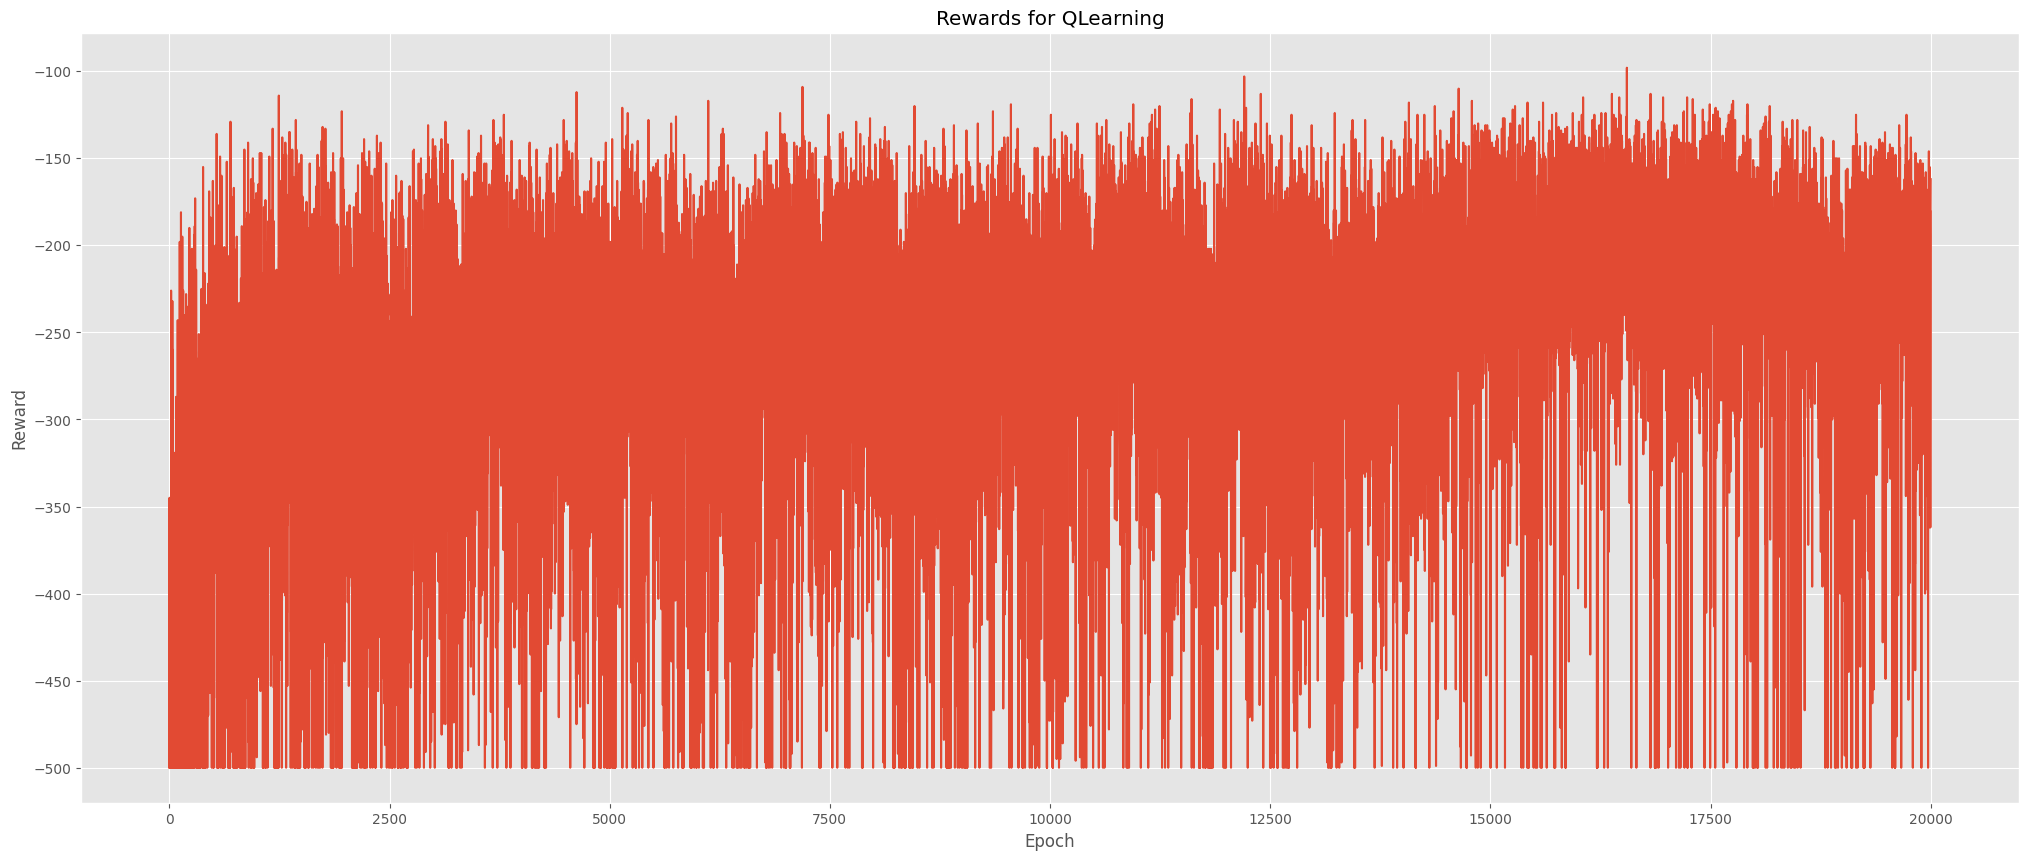

In [31]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(25, 10))
    plt.plot(rewards_q)
    plt.title('Rewards for QLearning')
    plt.xlabel('Epoch')
    plt.ylabel('Reward')
    print(f'Max reward = {max(rewards_q)} on iteration {rewards_q.tolist().index(max(rewards_q))}')

In [117]:
len(q)

1593015

In [8]:



mc_s = time.perf_counter()
rewards_mc = MonteCarlo(env, episode_n=500, trajectory_len=500, gamma=0.99)
mc_e = time.perf_counter()
time_mc = mc_e - mc_s


sarsa_s = time.perf_counter()
rewards_sarsa = SARSA(env, episode_n=500, gamma=0.99, trajectory_len=500, alpha=0.5)
sarsa_e = time.perf_counter()
time_sarsa = sarsa_e - sarsa_s


qlearning_s = time.perf_counter()
rewards_qlearning = QLearning(env, episode_n=500, noisy_episode_n=400, trajectory_len=1000, gamma=0.999, alpha=0.5)
qlearning_e = time.perf_counter()
time_qlearning = qlearning_e - qlearning_s



  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

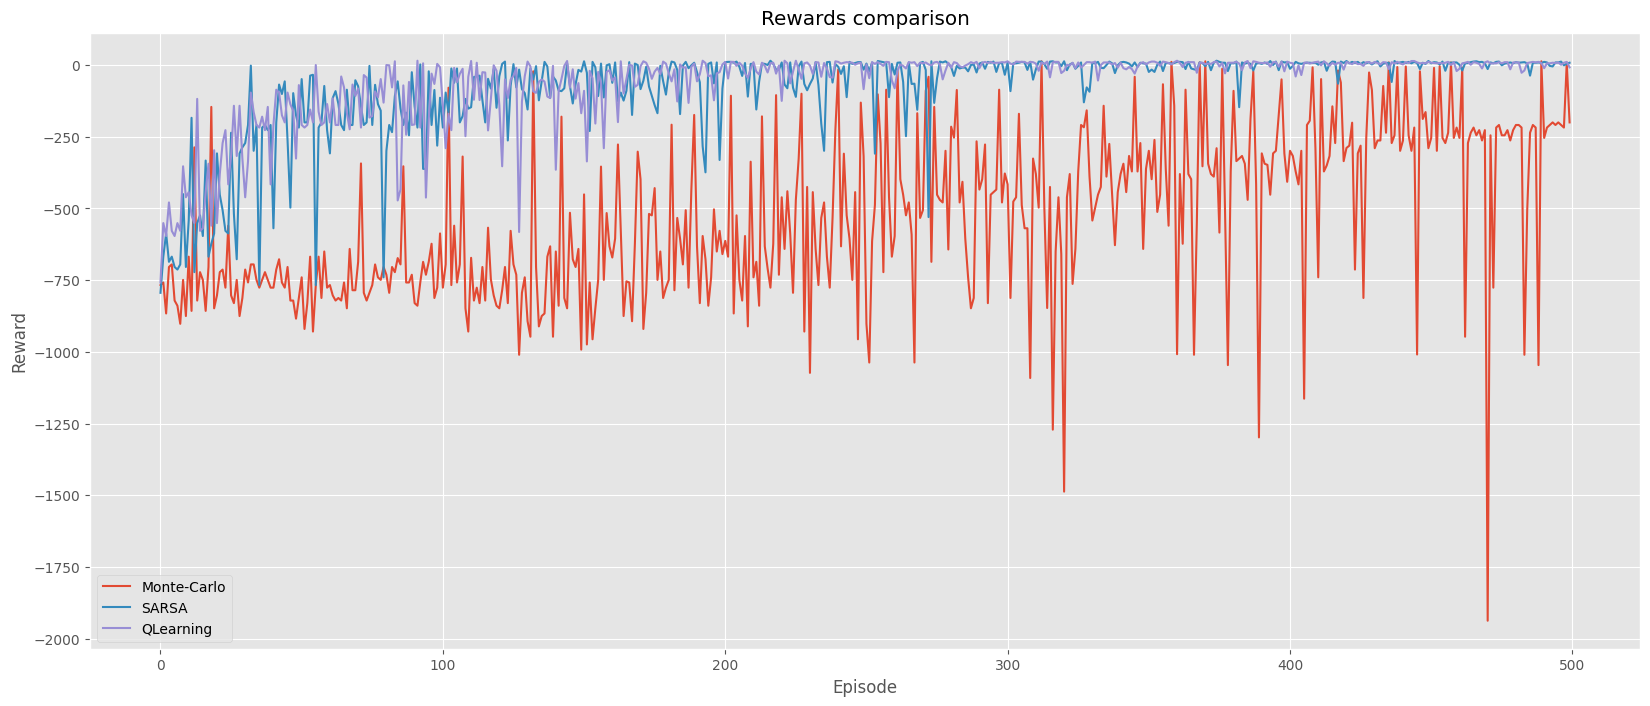

In [9]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(20, 8))
    plt.plot(rewards_mc, label='Monte-Carlo')
    plt.plot(rewards_sarsa, label='SARSA')
    plt.plot(rewards_qlearning, label='QLearning')
    plt.title('Rewards comparison')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend();

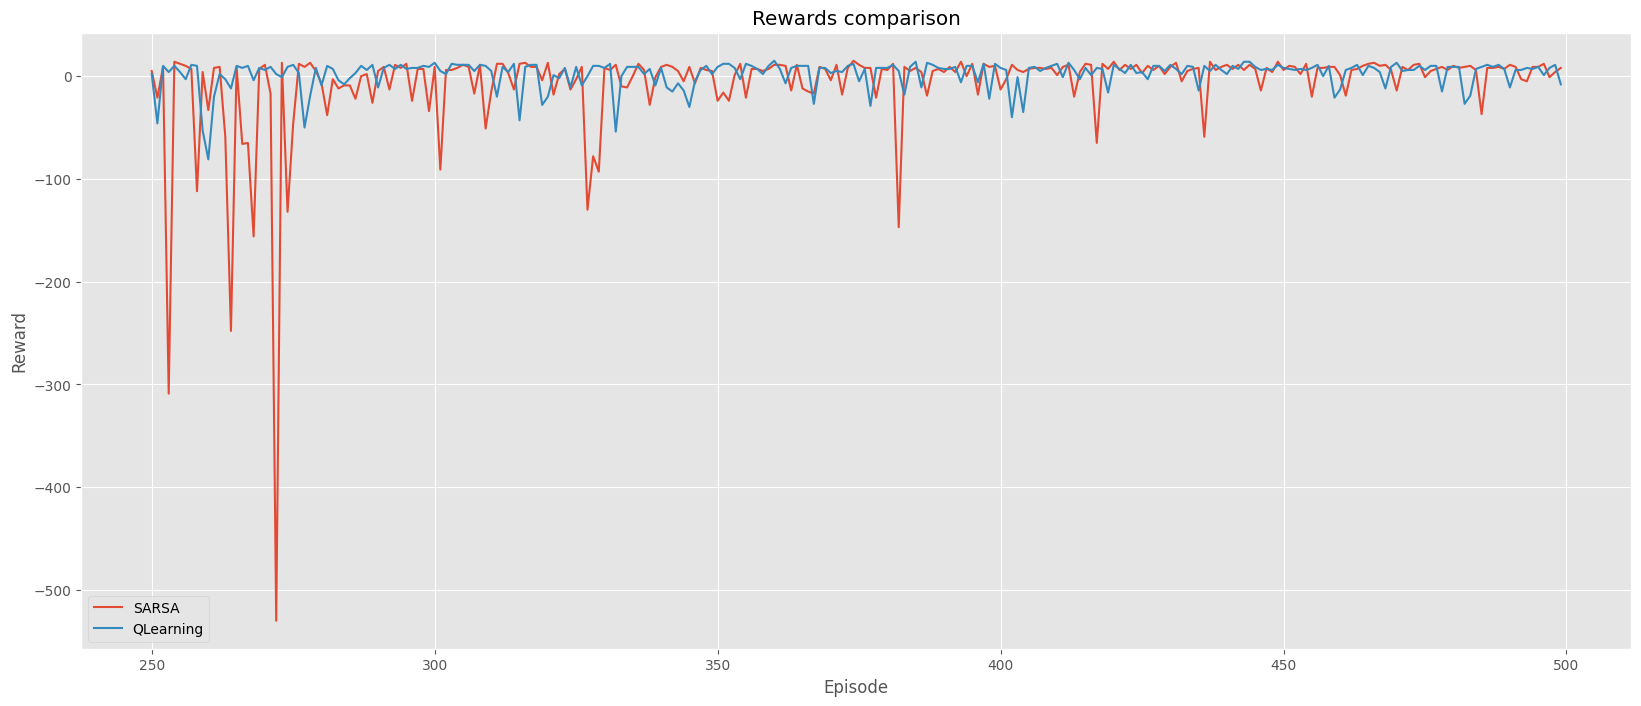

In [10]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(20, 8))
    plt.plot(np.arange(250, 500), rewards_sarsa[250:], label='SARSA')
    plt.plot(np.arange(250, 500), rewards_qlearning[250:], label='QLearning')
    plt.title('Rewards comparison')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend();

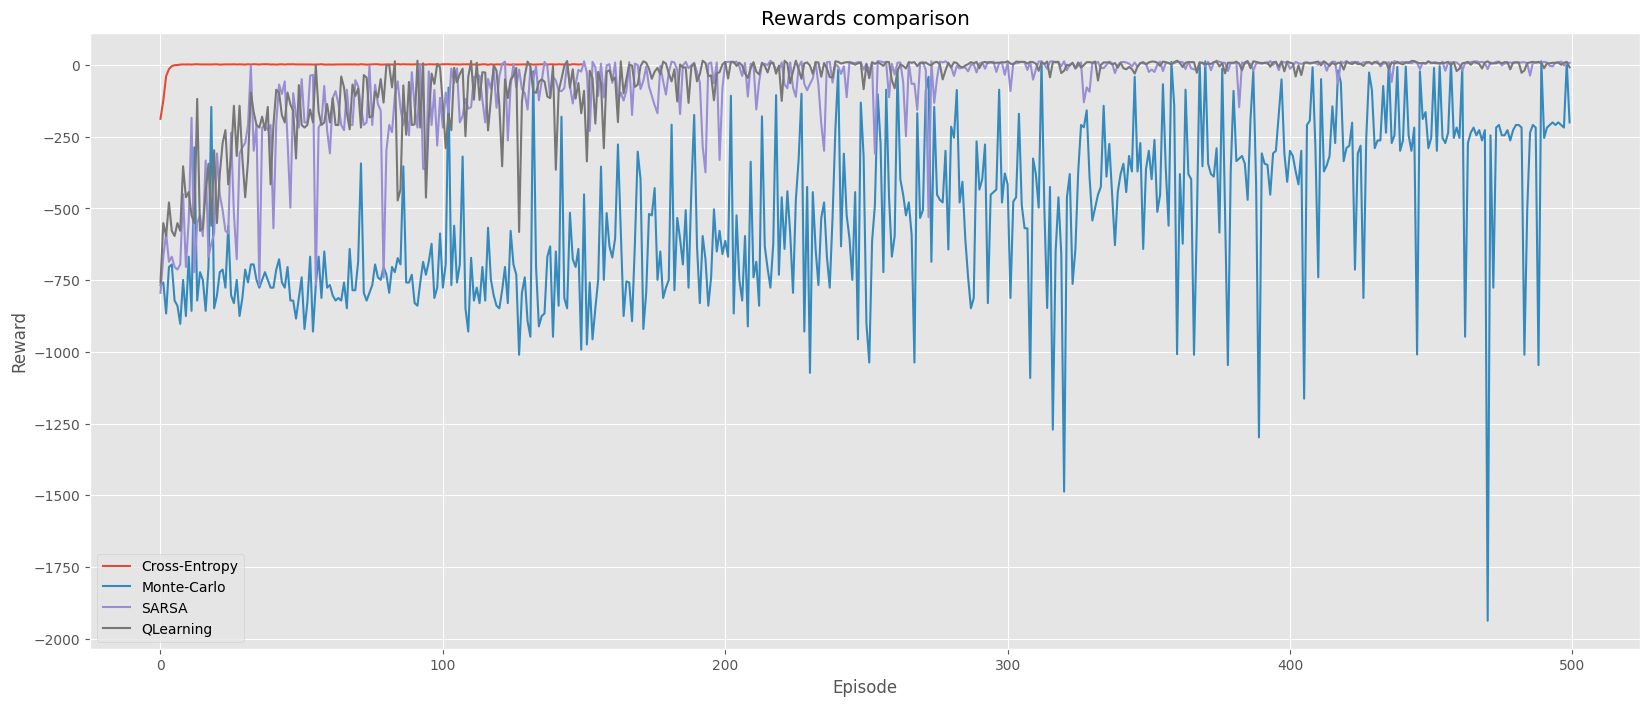

In [16]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(20, 8))
    plt.plot(rewards_cem, label='Cross-Entropy')
    plt.plot(rewards_mc, label='Monte-Carlo')
    plt.plot(rewards_sarsa, label='SARSA')
    plt.plot(rewards_qlearning, label='QLearning')
    plt.title('Rewards comparison')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend();

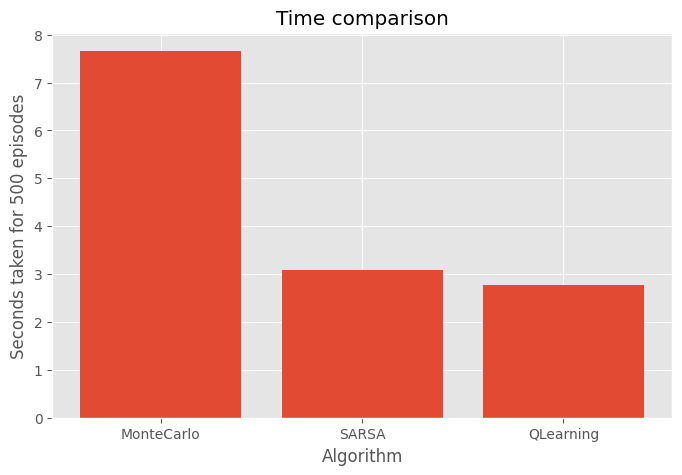

In [14]:
time_dict = {'MonteCarlo': time_mc, 'SARSA': time_sarsa, 'QLearning': time_qlearning}
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 5))
    plt.bar(time_dict.keys(), time_dict.values())
    plt.title('Time comparison')
    plt.xlabel('Algorithm')
    plt.ylabel('Seconds taken for 500 episodes')

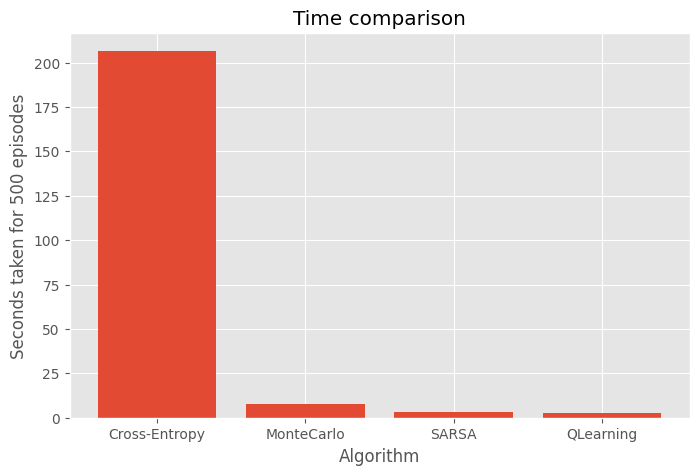

In [15]:
time_dict_with_ce = {'Cross-Entropy': time_cem, 'MonteCarlo': time_mc, 'SARSA': time_sarsa, 'QLearning': time_qlearning}
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 5))
    plt.bar(time_dict_with_ce.keys(), time_dict_with_ce.values())
    plt.title('Time comparison')
    plt.xlabel('Algorithm')
    plt.ylabel('Seconds taken for 500 episodes')